# Deep Neural Networks Laboration

Data used in this laboration are from the Kitsune Network Attack Dataset, https://archive.ics.uci.edu/ml/datasets/Kitsune+Network+Attack+Dataset . We will focus on the 'Mirai' part of the dataset. Your task is to make a DNN that can classify if each attack is benign or malicious. The dataset has 116 covariates, but to make it a bit more difficult we will remove the first 24 covariates.

You need to answer all questions in this notebook.

If the training is too slow on your own computer, use the smaller datasets (*half or *quarter).

Dense networks are not optimal for tabular datasets like the one used here, but here the main goal is to learn deep learning.

# Part 1: Get the data

Skip this part if you load stored numpy arrays (Mirai*.npy) (which is recommended)

Use `wget` in the terminal of your cloud machine (in the same directory as where you have saved this notebook) to download the data, i.e.

wget https://archive.ics.uci.edu/ml/machine-learning-databases/00516/mirai/Mirai_dataset.csv.gz

wget https://archive.ics.uci.edu/ml/machine-learning-databases/00516/mirai/Mirai_labels.csv.gz

Then unpack the files using `gunzip` in the terminal, i.e.

gunzip Mirai_dataset.csv.gz

gunzip Mirai_labels.csv.gz

# Part 2: Get a graphics card

Skip this part if you run on the CPU (recommended)

Lets make sure that our script can see the graphics card that will be used. The graphics cards will perform all the time consuming calculations in every training iteration.

In [ ]:
import os
import warnings

# Ignore FutureWarning from numpy
warnings.simplefilter(action='ignore', category=FutureWarning)

import keras.backend as K
import tensorflow as tf

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
 
# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="0";

# Allow growth of GPU memory, otherwise it will always look like all the memory is being used
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True) 

# Part 3: Hardware

In deep learning, the computer hardware is very important. You should always know what kind of hardware you are working on. Lets pretend that everyone is using an Nvidia RTX 3090 graphics card.

Question 1: Google the name of the graphics card, how many CUDA cores does it have?
##### Answer: It has 10496 CUDA cores


Question 2: How much memory does the graphics card have?
##### Answer: 24 GB

Question 3: What is stored in the GPU memory while training a DNN ?
##### Answer: The following information is stored in GPU memory
1. Input data (training data and validation data).
2. Model parameters including weights and biases that are learned during training. 
3. Outputs of activation functions at each layer in DNN during forward propagation.
4. The gradients of the loss function with respect to the model parameters that are computed during backward propagation.

# Part 4: Load the data

To make this step easier, directly load the data from saved numpy arrays (.npy) (recommended)


Load the dataset from the csv files, it will take some time since it is almost 1.4 GB. (not recommended, unless you want to learn how to do it)

We will use the function `genfromtxt` to load the data. (not recommended, unless you want to learn how to do it)

https://docs.scipy.org/doc/numpy/reference/generated/numpy.genfromtxt.html

Load the data from csv files the first time, then save the data as numpy files for faster loading the next time.

Remove the first 24 covariates to make the task harder.

In [1]:
from numpy import genfromtxt # Not needed if you load data from numpy arrays
import numpy as np

# Load data from numpy arrays, choose reduced files if the training takes too long
X = np.load('Mirai_data.npy')
Y = np.load('Mirai_labels.npy')



# Remove the first 24 covariates (columns)
X = X[:, 24:]

print('The covariates have size {}.'.format(X.shape))
print('The labels have size {}.'.format(Y.shape))

# Print the number of examples of each class
unique, count = np.unique(Y, return_counts=True)
print("The number of examples of class-{}: {}".format(int(unique[0]),count[0]))
print("The number of examples of class-{}: {}".format(int(unique[1]),count[1]))

The covariates have size (764137, 92).
The labels have size (764137,).
The number of examples of class-0: 121621
The number of examples of class-1: 642516


# Part 5: How good is a naive classifier?

Question 4: Given the number of examples from each class, how high classification performance can a naive classifier obtain? The naive classifier will assume that all examples belong to one class. Note: you do not need to make a naive classifier, this is a theoretical question, just to understand how good performance we can obtain by guessing that all examples belong to one class.

In all classification tasks you should always ask these questions

- How good classification accuracy can a naive classifier obtain? The naive classifier will assume that all examples belong to one class.
- What is random chance classification accuracy if you randomly guess the label of each (test) example? For a balanced dataset and binary classification this is easy (50%), but in many cases it is more complicated and a Monte Carlo simulation may be required to estimate random chance accuracy.

If your classifier cannot perform better than a naive classifier or a random classifier, you are doing something wrong.


#### Answer: 
The naive classifier assumes that all examples belong to one class. Since the dataset has more examples of class-1 i.e. 642516, the maximum accuracy that can a naive classifier get is 642516/(121621+642516) = 84.08%.

In [2]:
# It is common to have NaNs in the data, lets check for it. Hint: np.isnan()
np.isnan(X)

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [3]:
# Print the number of NaNs (not a number) in the labels
print("The number of NaNs in the labels : {}".format(sum(np.isnan(Y))))

# Print the number of NaNs in the covariates
print("The total number of NaNs in the covariates is {} ".format(np.sum(sum(np.isnan(X)))))

The number of NaNs in the labels : 0
The total number of NaNs in the covariates is 0 


# Part 6: Preprocessing

Lets do some simple preprocessing

In [4]:
# Convert covariates to floats
X = X.astype(np.float64)

# Convert labels to integers
Y= Y.astype(np.int64)

# Remove mean of each covariate (column)
X_mean = np.mean(X, axis=0)
X = X-X_mean

# Divide each covariate (column) by its standard deviation
X_sd = np.std(X, axis=0)
X = X / X_sd

# Check that mean is 0 and standard deviation is 1 for all covariates, by printing mean and std
print("Mean of each covariate is",np.mean(X,axis=0))
print("Standard deviation of each covariate is ",np.std(X,axis=0))

Mean of each covariate is [-3.19451533e-18 -6.32970181e-14  1.19926356e-13  4.56743018e-15
  4.10210037e-14  1.46130975e-13  5.85246484e-16 -1.69734859e-14
 -3.36915700e-13  1.28688437e-12 -2.69360995e-12 -1.10733213e-13
 -1.22392702e-13 -1.70649630e-13 -1.02461166e-14  2.50701280e-12
  1.47553162e-12  1.08446837e-12 -1.04981959e-13  6.83458762e-14
 -1.03373555e-13  5.98825773e-14 -1.02025960e-12 -1.68983055e-12
 -1.79101143e-12 -1.31828514e-13  4.42580403e-13  6.14635580e-13
  5.78048199e-14 -4.92623328e-13 -2.54513072e-12  1.86544900e-13
 -1.53444593e-13  1.68079591e-12  9.30041709e-13  1.50738177e-13
 -1.15688852e-12 -3.62610361e-13 -1.71390937e-12 -2.09264067e-13
  1.07161976e-12 -1.45236885e-12 -1.69724579e-14 -1.64918984e-16
 -5.13444996e-14 -1.02171349e-14 -1.74685907e-15  1.34264921e-13
  5.98801969e-14  1.48745574e-17 -4.25442340e-13  5.78079594e-14
  1.25638129e-15  1.69449684e-13  1.50725881e-13  2.14439542e-14
  3.65457183e-14  1.17260451e-13 -8.82752870e-13 -6.34816648e-13

# Part 7: Split the dataset

Use the first 70% of the dataset for training, leave the other 30% for validation and test, call the variables

Xtrain (70%)

Xtemp  (30%)

Ytrain (70%)

Ytemp  (30%)

We use a function from scikit learn.
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html


In [5]:
from sklearn.model_selection import train_test_split

# Your code to split the dataset
Xtrain, Xtemp, Ytrain, Ytemp = train_test_split(X, Y, test_size=0.3, random_state=20)

print('Xtrain has size {}.'.format(Xtrain.shape))
print('Ytrain has size {}.'.format(Ytrain.shape))

print('Xtemp has size {}.'.format(Xtemp.shape))
print('Ytemp has size {}.'.format(Ytemp.shape))

# Print the number of examples of each class, for the training data and the remaining 30%
unique, count = np.unique(Ytrain, return_counts=True)
print("The number of examples in training data of class-{}: {}".format(int(unique[0]),count[0]))
print("The number of examples in training data of class-{}: {}".format(int(unique[1]),count[1]))

unique, count = np.unique(Ytemp, return_counts=True)
print("The number of examples in validation & test data of class-{}: {}".format(int(unique[0]),count[0]))
print("The number of examples in validation & test data of class-{}: {}".format(int(unique[1]),count[1]))


Xtrain has size (534895, 92).
Ytrain has size (534895,).
Xtemp has size (229242, 92).
Ytemp has size (229242,).
The number of examples in training data of class-0: 84916
The number of examples in training data of class-1: 449979
The number of examples in validation & test data of class-0: 36705
The number of examples in validation & test data of class-1: 192537


#  Part 8: Split non-training data data into validation and test
Now split your non-training data (Xtemp, Ytemp) into 50% validation (Xval, Yval) and 50% testing (Xtest, Ytest), we use a function from scikit learn. In total this gives us 70% for training, 15% for validation, 15% for test.

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

Do all variables (Xtrain,Ytrain), (Xval,Yval), (Xtest,Ytest) have the shape that you expect?

In [6]:
from sklearn.model_selection import train_test_split

# Your code
Xval, Xtest, Yval, Ytest = train_test_split(Xtemp, Ytemp, test_size=0.5, random_state=20)

print('The validation and test data have size {}, {}, {} and {}'.format(Xval.shape, Xtest.shape, Yval.shape, Ytest.shape))

The validation and test data have size (114621, 92), (114621, 92), (114621,) and (114621,)


# Part 9: DNN classification

Finish this code to create a first version of the classifier using a DNN. Start with a simple network with 2 dense layers (with 20 nodes each), using sigmoid activation functions. The final dense layer should have a single node and a sigmoid activation function. We start with the SGD optimizer.

For different parts of this notebook you need to go back here, add more things, and re-run this cell to re-define the build function.

Relevant functions are

`model.add()`, adds a layer to the network

`Dense()`, a dense network layer

`model.compile()`, compile the model, add " metrics=['accuracy'] " to print the classification accuracy during the training

See https://keras.io/layers/core/ for information on how the `Dense()` function works

Import a relevant cost / loss function for binary classification from keras.losses (https://keras.io/losses/)

See the following links for how to compile, train and evaluate the model

https://keras.io/api/models/model_training_apis/#compile-method

https://keras.io/api/models/model_training_apis/#fit-method

https://keras.io/api/models/model_training_apis/#evaluate-method

Make sure that the last layer always has a sigmoid activation function (why?).


In [7]:
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD, Adam
from keras.losses import binary_crossentropy


# Set seed from random number generator, for better comparisons
from numpy.random import seed
seed(123)

def build_DNN(input_shape, n_layers, n_nodes, act_fun='sigmoid', optimizer='sgd', learning_rate=0.01, 
              use_bn=False, use_dropout=False, use_custom_dropout=False):
    
    # Setup optimizer, depending on input parameter string
    if optimizer == 'sgd':
        opt = SGD(learning_rate=learning_rate)
    else:
        opt = Adam(learning_rate=learning_rate)
        
    # Setup a sequential model
    model = Sequential()

    # Add layers to the model, using the input parameters of the build_DNN function
    if use_bn is True:
        model.add(BatchNormalization())
    if use_dropout is True:
        model.add(Dropout(rate=0.5))
    if use_custom_dropout is True:
        model.add(myDropout(0.5))
    
    # Add first layer, requires input shape
    model.add(Dense(n_nodes, activation=act_fun, input_shape=input_shape))
    
    # Add remaining layers, do not require input shape
    for i in range(n_layers-1):
        model.add(Dense(n_nodes, activation=act_fun))
        if use_bn is True:
            model.add(BatchNormalization())
        if use_dropout is True:
            model.add(Dropout(rate=0.5))
        if use_custom_dropout is True:
            model.add(myDropout(0.5))
    
    
    # Add final layer
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return model

In [8]:
# Lets define a help function for plotting the training results

import matplotlib.pyplot as plt
def plot_results(history):
    
    val_loss = history.history['val_loss']
    acc = history.history['accuracy']
    loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    
    plt.figure(figsize=(10,4))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(loss)
    plt.plot(val_loss)
    plt.legend(['Training','Validation'])

    plt.figure(figsize=(10,4))
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(acc)
    plt.plot(val_acc)
    plt.legend(['Training','Validation'])

    plt.show()

# Part 10: Train the DNN

Time to train the DNN, we start simple with 2 layers with 20 nodes each, learning rate 0.1.

Relevant functions

`build_DNN`, the function we defined in Part 9, call it with the parameters you want to use

`model.fit()`, train the model with some training data

`model.evaluate()`, apply the trained model to some test data

See the following links for how to train and evaluate the model

https://keras.io/api/models/model_training_apis/#fit-method

https://keras.io/api/models/model_training_apis/#evaluate-method


Make sure that you are using learning rate 0.1 !

### 2 layers, 20 nodes

In [9]:
# Setup some training parameters
batch_size = 10000
epochs = 20

input_shape = (Xtrain.shape[1],)


# Build the model
model1 = build_DNN(input_shape=input_shape, n_layers=2,n_nodes=20,learning_rate=0.1)

# Train the model, provide training data and validation data
history1 = model1.fit(Xtrain,Ytrain,batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(Xval,Yval))

Epoch 1/20
54/54 [==============================] - 8s 57ms/step - loss: 0.4473 - accuracy: 0.8285 - val_loss: 0.4094 - val_accuracy: 0.8398
Epoch 2/20
54/54 [==============================] - 1s 24ms/step - loss: 0.3876 - accuracy: 0.8412 - val_loss: 0.3672 - val_accuracy: 0.8398
Epoch 3/20
54/54 [==============================] - 1s 19ms/step - loss: 0.3410 - accuracy: 0.8412 - val_loss: 0.3155 - val_accuracy: 0.8398
Epoch 4/20
54/54 [==============================] - 1s 16ms/step - loss: 0.2892 - accuracy: 0.8412 - val_loss: 0.2660 - val_accuracy: 0.8398
Epoch 5/20
54/54 [==============================] - 1s 18ms/step - loss: 0.2471 - accuracy: 0.8480 - val_loss: 0.2321 - val_accuracy: 0.8561
Epoch 6/20
54/54 [==============================] - 1s 19ms/step - loss: 0.2213 - accuracy: 0.8732 - val_loss: 0.2132 - val_accuracy: 0.8858
Epoch 7/20
54/54 [==============================] - 1s 21ms/step - loss: 0.2070 - accuracy: 0.8950 - val_loss: 0.2027 - val_accuracy: 0.9012
Epoch 8/20
54

In [10]:
# Evaluate the model on the test data
score = model1.evaluate(Xtest,Ytest)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

3582/3582 [==============================] - 15s 4ms/step - loss: 0.1743 - accuracy: 0.9066
Test loss: 0.1743
Test accuracy: 0.9066


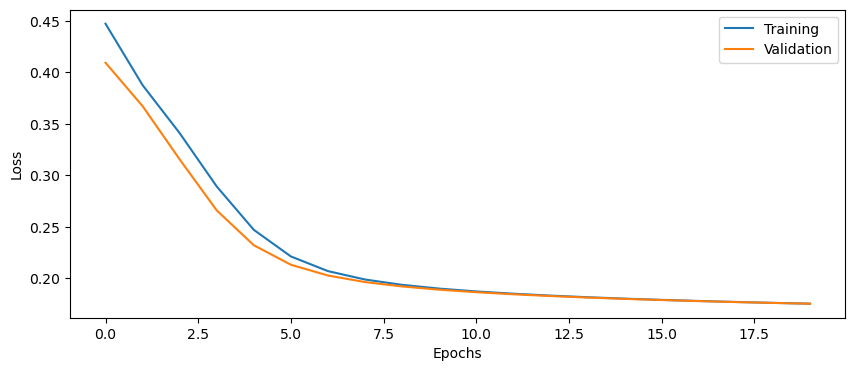

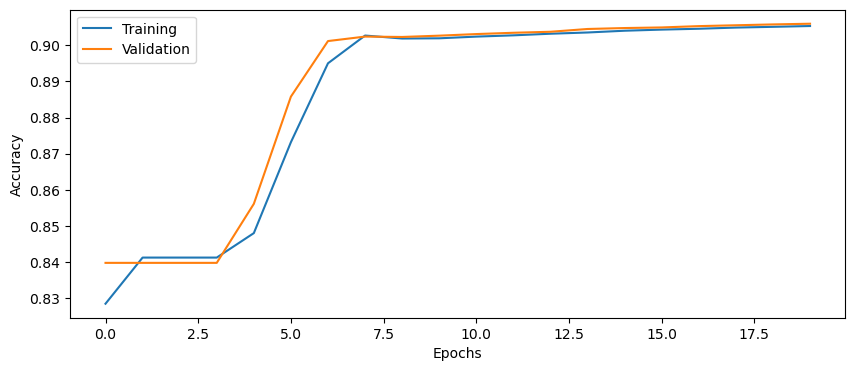

In [11]:
# Plot the history from the training run
plot_results(history1)

# Part 11: More questions

Question 5: What happens if you add several Dense layers without specifying the activation function?
#### Answer: 
If we add several Dense layers without specifying the activation function, the model will take "linear activation function" as default. The output of each layer is just weighted sum of the inputs which means that the subsequent layers will just be a linear combination of the previous layers. This will make the model unable to capture complex non-linear patterns in the data.


Question 6: How are the weights in each dense layer initialized as default? How are the bias weights initialized?
#### Answer:
In Keras, the weights in each Dense layer are initialized using the "Glorot uniform" initialization by default. 

The bias weights in each Dense layer are initialized to zero by default.

Ref:https://keras.io/api/layers/core_layers/dense/

# Part 12: Balancing the classes

This dataset is rather unbalanced, we need to define class weights so that the training pays more attention to the class with fewer samples. We use a function in scikit learn

https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html

You need to call the function something like this

class_weights = class_weight.compute_class_weight(class_weight = , classes = , y = )

otherwise it will complain

In [12]:
from sklearn.utils import class_weight

# Calculate class weights
class_weights = class_weight.compute_class_weight(class_weight ='balanced', classes =np.unique(Ytrain), y=Ytrain)

# Print the class weights
print(class_weights)
# Keras wants the weights in this form, uncomment and change value1 and value2 to your weights, 
# or get them from the array that is returned from class_weight

class_weights = {0: class_weights[0], 1: class_weights[1]}


[3.14955368 0.59435551]


### 2 layers, 20 nodes, class weights

In [13]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = (Xtrain.shape[1],)

# Build and train model
model2 = build_DNN(input_shape=input_shape, n_layers=2,n_nodes=20,learning_rate=0.1)

history2 = model2.fit(Xtrain,Ytrain,batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(Xval,Yval),class_weight=class_weights)

Epoch 1/20
54/54 [==============================] - 6s 40ms/step - loss: 0.6364 - accuracy: 0.8722 - val_loss: 0.5630 - val_accuracy: 0.8864
Epoch 2/20
54/54 [==============================] - 1s 20ms/step - loss: 0.4746 - accuracy: 0.8845 - val_loss: 0.3959 - val_accuracy: 0.8854
Epoch 3/20
54/54 [==============================] - 1s 16ms/step - loss: 0.3245 - accuracy: 0.8842 - val_loss: 0.3081 - val_accuracy: 0.8840
Epoch 4/20
54/54 [==============================] - 1s 16ms/step - loss: 0.2571 - accuracy: 0.8837 - val_loss: 0.2799 - val_accuracy: 0.8848
Epoch 5/20
54/54 [==============================] - 1s 16ms/step - loss: 0.2321 - accuracy: 0.8849 - val_loss: 0.2683 - val_accuracy: 0.8864
Epoch 6/20
54/54 [==============================] - 1s 17ms/step - loss: 0.2204 - accuracy: 0.8869 - val_loss: 0.2621 - val_accuracy: 0.8887
Epoch 7/20
54/54 [==============================] - 1s 16ms/step - loss: 0.2136 - accuracy: 0.8894 - val_loss: 0.2576 - val_accuracy: 0.8911
Epoch 8/20
54

In [14]:
# Evaluate model on test data
score = model2.evaluate(Xtest,Ytest)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

3582/3582 [==============================] - 14s 4ms/step - loss: 0.2323 - accuracy: 0.9013
Test loss: 0.2323
Test accuracy: 0.9013


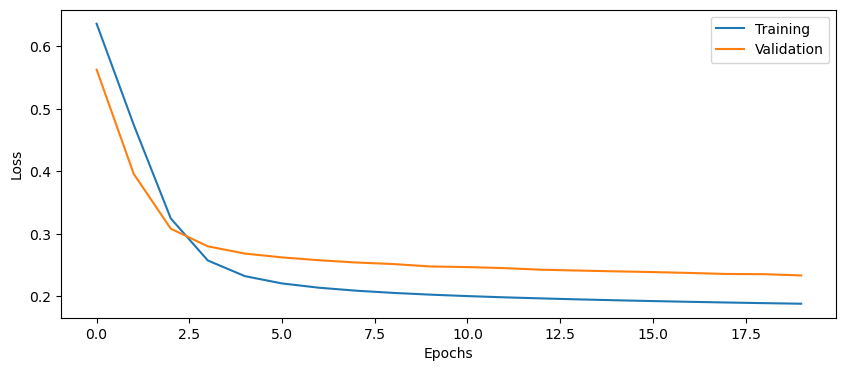

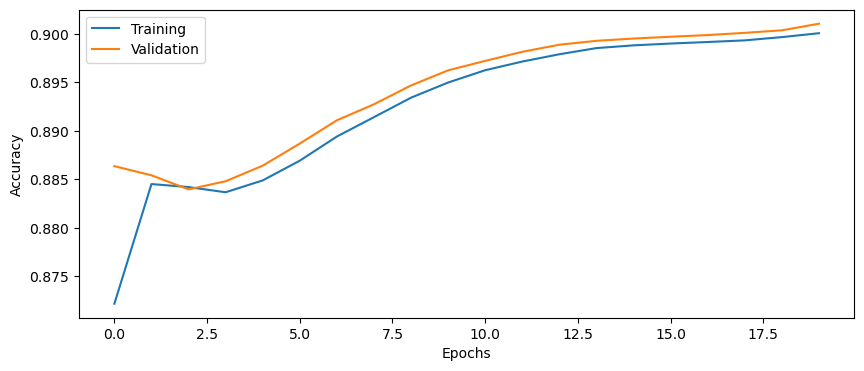

In [15]:
plot_results(history2)

# Part 13: More questions

Skip questions 8 and 9 if you run on the CPU (recommended)

Question 7: Why do we have to use a batch size? Why can't we simply use all data at once? This is more relevant for even larger datasets.
##### Answer:
The reason for using a batch size is computational efficiency. If you use all data at once especially on large datasets, it becomes computationally expensive and there is a chance of model becoming overfit. Using a batch size will improve the generalized performance of the model.


Question 8: How busy is the GPU for a batch size of 100? How much GPU memory is used? Hint: run 'nvidia-smi' on the computer a few times during training.

Question 9: What is the processing time for one training epoch when the batch size is 100? What is the processing time for one epoch when the batch size is 1,000? What is the processing time for one epoch when the batch size is 10,000? Explain the results. 

Question 10: How many times are the weights in the DNN updated in each training epoch if the batch size is 100? How many times are the weights in the DNN updated in each training epoch if the batch size is 1,000? How many times are the weights in the DNN updated in each training epoch if the batch size is 10,000? 
##### Answer:
The weights in DNN are updated once for every batch size of training samples. Total training samples are 534895.

- if the batch size is 100 then weights are updated 5349 (534895/100 = 5348.95) times in each training epoch.
- if the batch size is 1000 then weights are updated 535 (534895/1000 = 534.895) times in each training epoch.
- if the batch size is 10000 then weights are updated 54 (534895/100 = 53.4895) times in each training epoch.

Question 11: What limits how large the batch size can be?
##### Answer:
Theoritically the batch size can be equal to the number of observations in the training dataset but it is not recommended in practice. Large batch size requires more memory to store weights, activations and gradients during training process which sometimes results in slow down the trining process due to insufficient memory. It takes much time to converge the model due to this weight updation becomes slow. Large batch size can lead to overfitting the model.

Question 12: Generally speaking, how is the learning rate related to the batch size? If the batch size is decreased, how should the learning rate be changed?
##### Answer:
If the batch size is decreased, the learning rate should be increased proportionally to maintain the convergence at similar rate because the model with reduced batch size updates the weights more frequently with less accurate gradients. 





Lets use a batch size of 10,000 from now on, and a learning rate of 0.1.

In [27]:
#To know trainable parameters in initial network with 2 layers and 20 nodes per layer 
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 20)                1860      
                                                                 
 dense_4 (Dense)             (None, 20)                420       
                                                                 
 dense_5 (Dense)             (None, 1)                 21        
                                                                 
Total params: 2,301
Trainable params: 2,301
Non-trainable params: 0
_________________________________________________________________


In [28]:
#To know trainable parameters in initial network with 4 layers and 50 nodes per layer 
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = (Xtrain.shape[1],)

# Build and train model
model3a = build_DNN(input_shape=input_shape, n_layers=4,n_nodes=50,learning_rate=0.1)
model3a.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_29 (Dense)            (None, 50)                4650      
                                                                 
 dense_30 (Dense)            (None, 50)                2550      
                                                                 
 dense_31 (Dense)            (None, 50)                2550      
                                                                 
 dense_32 (Dense)            (None, 50)                2550      
                                                                 
 dense_33 (Dense)            (None, 1)                 51        
                                                                 
Total params: 12,351
Trainable params: 12,351
Non-trainable params: 0
_________________________________________________________________


# Part 14: Increasing the complexity

Lets try some different configurations of number of layers and number of nodes per layer.

Question 13: How many trainable parameters does the network with 4 dense layers with 50 nodes each have, compared to the initial network with 2 layers and 20 nodes per layer? Hint: use model.summary()
##### Answer:
- Initial network with 2 layers and 20 nodes per layer has 2301 trainable parameters.
- The network with 4 dense layers with 50 nodes each has 12351 trainable parameters.

### 4 layers, 20 nodes, class weights

In [16]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = (Xtrain.shape[1],)

# Build and train model
model3 = build_DNN(input_shape=input_shape, n_layers=4,n_nodes=20,learning_rate=0.1)

history3 = model3.fit(Xtrain,Ytrain,batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(Xval,Yval),class_weight=class_weights)

Epoch 1/20
54/54 [==============================] - 9s 89ms/step - loss: 0.6941 - accuracy: 0.4629 - val_loss: 0.6955 - val_accuracy: 0.1641
Epoch 2/20
54/54 [==============================] - 3s 56ms/step - loss: 0.6937 - accuracy: 0.4372 - val_loss: 0.6933 - val_accuracy: 0.1529
Epoch 3/20
54/54 [==============================] - 2s 43ms/step - loss: 0.6933 - accuracy: 0.5066 - val_loss: 0.6915 - val_accuracy: 0.8390
Epoch 4/20
54/54 [==============================] - 2s 31ms/step - loss: 0.6928 - accuracy: 0.6275 - val_loss: 0.6957 - val_accuracy: 0.1602
Epoch 5/20
54/54 [==============================] - 2s 32ms/step - loss: 0.6924 - accuracy: 0.6160 - val_loss: 0.6935 - val_accuracy: 0.1675
Epoch 6/20
54/54 [==============================] - 2s 34ms/step - loss: 0.6920 - accuracy: 0.6674 - val_loss: 0.6914 - val_accuracy: 0.8880
Epoch 7/20
54/54 [==============================] - 2s 33ms/step - loss: 0.6915 - accuracy: 0.7151 - val_loss: 0.6928 - val_accuracy: 0.7208
Epoch 8/20
54

In [20]:
# Evaluate model on test data
score = model3.evaluate(Xtest,Ytest)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

3582/3582 [==============================] - 15s 4ms/step - loss: 0.6102 - accuracy: 0.8847
Test loss: 0.6102
Test accuracy: 0.8847


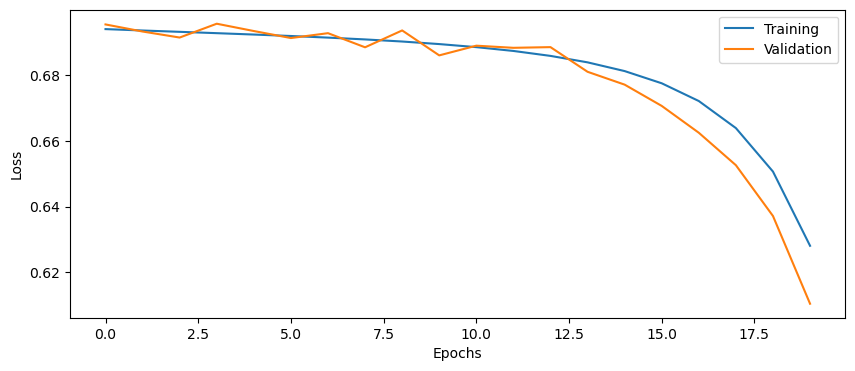

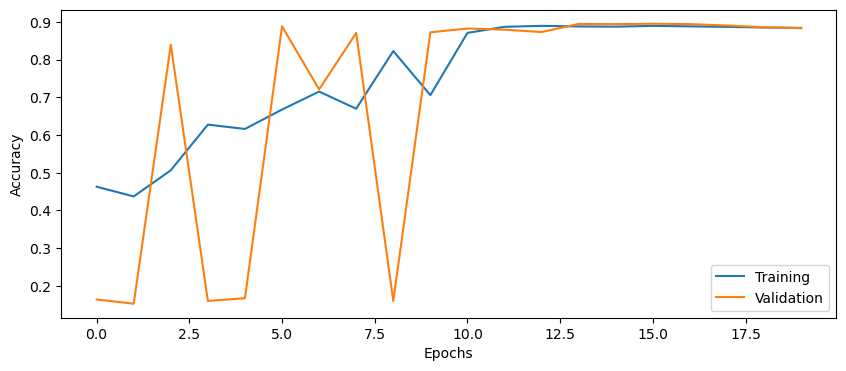

In [21]:
plot_results(history3)

### 2 layers, 50 nodes, class weights

In [22]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = (Xtrain.shape[1],)

# Build and train model
model4 = build_DNN(input_shape=input_shape, n_layers=2,n_nodes=50,learning_rate=0.1)

history4 = model4.fit(Xtrain,Ytrain,batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(Xval,Yval),class_weight=class_weights)

Epoch 1/20
54/54 [==============================] - 5s 37ms/step - loss: 0.6078 - accuracy: 0.8143 - val_loss: 0.5118 - val_accuracy: 0.8812
Epoch 2/20
54/54 [==============================] - 1s 21ms/step - loss: 0.3952 - accuracy: 0.8811 - val_loss: 0.3301 - val_accuracy: 0.8823
Epoch 3/20
54/54 [==============================] - 1s 21ms/step - loss: 0.2727 - accuracy: 0.8814 - val_loss: 0.2868 - val_accuracy: 0.8823
Epoch 4/20
54/54 [==============================] - 1s 22ms/step - loss: 0.2359 - accuracy: 0.8840 - val_loss: 0.2723 - val_accuracy: 0.8860
Epoch 5/20
54/54 [==============================] - 1s 22ms/step - loss: 0.2220 - accuracy: 0.8872 - val_loss: 0.2630 - val_accuracy: 0.8888
Epoch 6/20
54/54 [==============================] - 1s 22ms/step - loss: 0.2144 - accuracy: 0.8899 - val_loss: 0.2578 - val_accuracy: 0.8914
Epoch 7/20
54/54 [==============================] - 2s 29ms/step - loss: 0.2092 - accuracy: 0.8917 - val_loss: 0.2533 - val_accuracy: 0.8930
Epoch 8/20
54

In [23]:
# Evaluate model on test data
score = model4.evaluate(Xtest,Ytest)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

3582/3582 [==============================] - 15s 4ms/step - loss: 0.2303 - accuracy: 0.9029
Test loss: 0.2303
Test accuracy: 0.9029


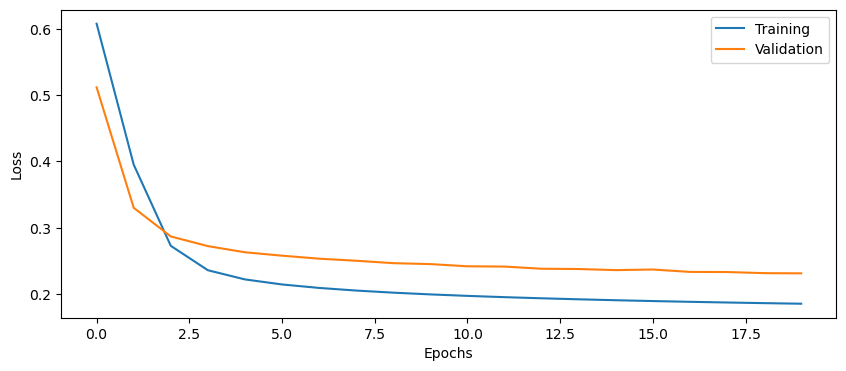

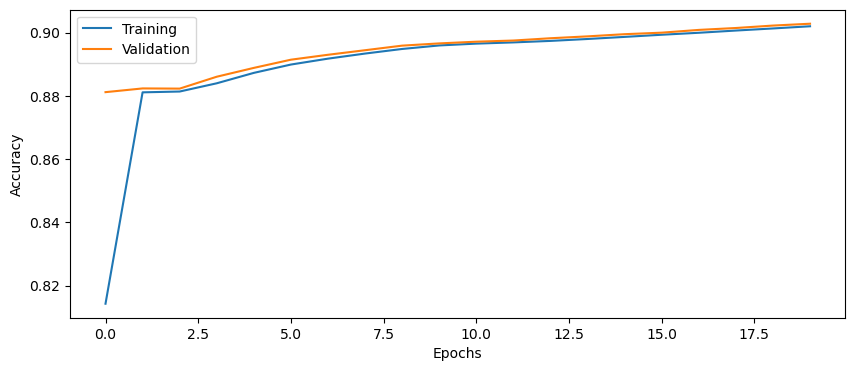

In [24]:
plot_results(history4)

### 4 layers, 50 nodes, class weights

In [25]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = (Xtrain.shape[1],)

# Build and train model
model5 = build_DNN(input_shape=input_shape, n_layers=4,n_nodes=50,learning_rate=0.1)

history5 = model5.fit(Xtrain,Ytrain,batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(Xval,Yval),class_weight=class_weights)

Epoch 1/20
54/54 [==============================] - 6s 55ms/step - loss: 0.6932 - accuracy: 0.4888 - val_loss: 0.6978 - val_accuracy: 0.1602
Epoch 2/20
54/54 [==============================] - 2s 35ms/step - loss: 0.6919 - accuracy: 0.5804 - val_loss: 0.6945 - val_accuracy: 0.1598
Epoch 3/20
54/54 [==============================] - 2s 36ms/step - loss: 0.6906 - accuracy: 0.6631 - val_loss: 0.6917 - val_accuracy: 0.8776
Epoch 4/20
54/54 [==============================] - 2s 33ms/step - loss: 0.6891 - accuracy: 0.7835 - val_loss: 0.6871 - val_accuracy: 0.8774
Epoch 5/20
54/54 [==============================] - 2s 36ms/step - loss: 0.6871 - accuracy: 0.8424 - val_loss: 0.6893 - val_accuracy: 0.8783
Epoch 6/20
54/54 [==============================] - 2s 41ms/step - loss: 0.6845 - accuracy: 0.8765 - val_loss: 0.6842 - val_accuracy: 0.8747
Epoch 7/20
54/54 [==============================] - 2s 39ms/step - loss: 0.6806 - accuracy: 0.8315 - val_loss: 0.6642 - val_accuracy: 0.8593
Epoch 8/20
54

In [29]:
# Evaluate model on test data
score = model5.evaluate(Xtest,Ytest)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

3582/3582 [==============================] - 15s 4ms/step - loss: 0.2514 - accuracy: 0.8915
Test loss: 0.2514
Test accuracy: 0.8915


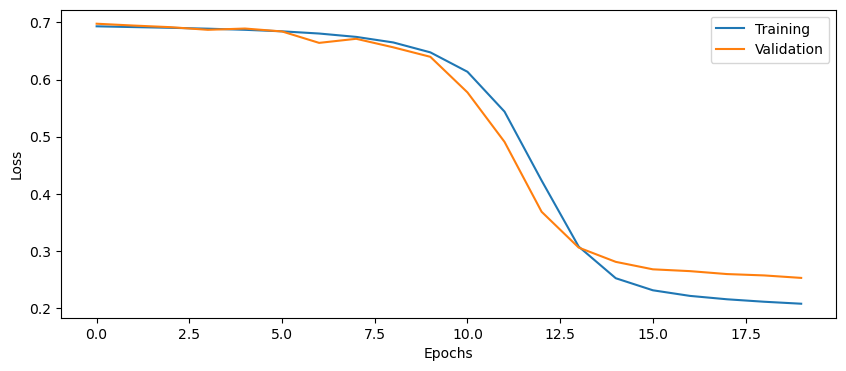

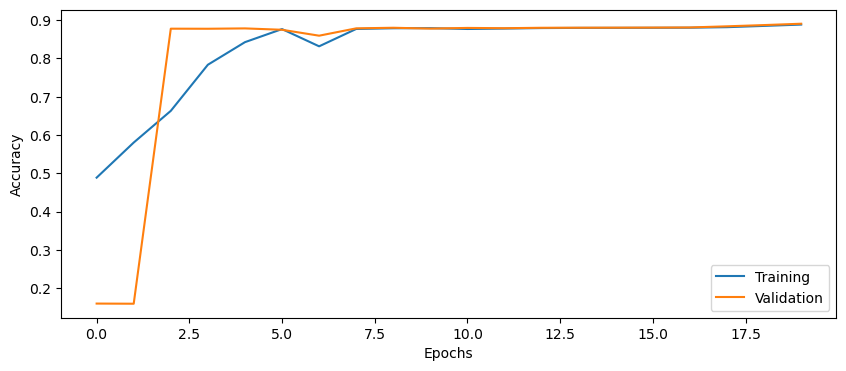

In [30]:
plot_results(history5)

# Part 15: Batch normalization

Now add batch normalization after each dense layer in `build_DNN`. Remember to import BatchNormalization from keras.layers. 

See https://keras.io/layers/normalization/ for information about how to call the function.

Question 14: Why is batch normalization important when training deep networks?
##### Answer:
Batch normalization is important during training of deep neural networks because it stabilizes and speeds up the training process.

When input propagates thorugh the layers, the mean and variance of the of input at each layer may change which can lead the gradients to become too small or too large. Batch normalization solves this problem by normalizing the input to each layer in a batch of training samples.  

Batch normalization solves this issue by normalizing the input to each layer in a batch of training samples. This helps ensure that the mean and variance of the input to each layer are approximately constant, which can make it easier to train the model effectively. 



### 2 layers, 20 nodes, class weights, batch normalization

In [31]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = (Xtrain.shape[1],)

# Build and train model
model6 = build_DNN(input_shape=input_shape, n_layers=2, n_nodes=20,learning_rate=0.1,use_bn=True)

history6 = model6.fit(Xtrain,Ytrain,batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(Xval,Yval),class_weight=class_weights)

Epoch 1/20
54/54 [==============================] - 12s 92ms/step - loss: 0.3376 - accuracy: 0.8575 - val_loss: 0.4839 - val_accuracy: 0.8398
Epoch 2/20
54/54 [==============================] - 2s 39ms/step - loss: 0.2258 - accuracy: 0.8967 - val_loss: 0.3820 - val_accuracy: 0.8398
Epoch 3/20
54/54 [==============================] - 2s 31ms/step - loss: 0.2049 - accuracy: 0.9013 - val_loss: 0.3494 - val_accuracy: 0.8398
Epoch 4/20
54/54 [==============================] - 1s 27ms/step - loss: 0.1949 - accuracy: 0.9053 - val_loss: 0.3326 - val_accuracy: 0.8398
Epoch 5/20
54/54 [==============================] - 2s 28ms/step - loss: 0.1891 - accuracy: 0.9071 - val_loss: 0.3094 - val_accuracy: 0.8398
Epoch 6/20
54/54 [==============================] - 2s 28ms/step - loss: 0.1852 - accuracy: 0.9080 - val_loss: 0.2823 - val_accuracy: 0.8398
Epoch 7/20
54/54 [==============================] - 2s 28ms/step - loss: 0.1822 - accuracy: 0.9092 - val_loss: 0.2528 - val_accuracy: 0.8399
Epoch 8/20
5

In [32]:
# Evaluate model on test data
score = model6.evaluate(Xtest,Ytest)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

3582/3582 [==============================] - 14s 4ms/step - loss: 0.2015 - accuracy: 0.9156
Test loss: 0.2015
Test accuracy: 0.9156


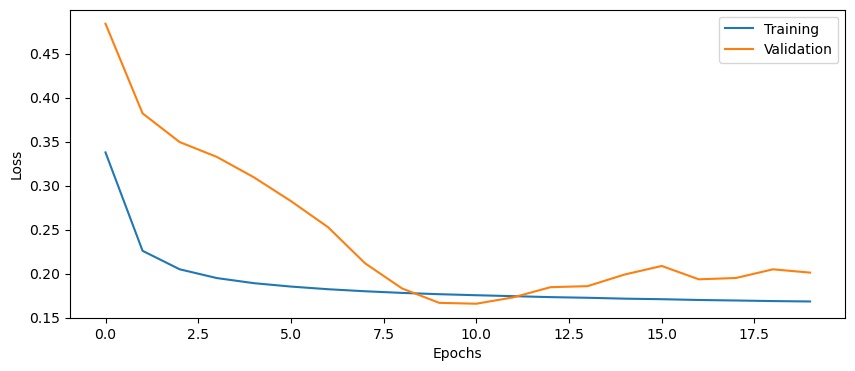

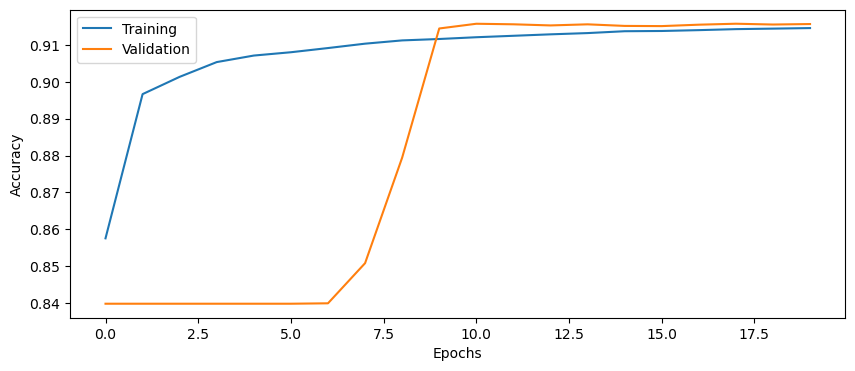

In [33]:
plot_results(history6)

# Part 16: Activation function

Try changing the activation function in each layer from sigmoid to ReLU, write down the test accuracy.

Note: the last layer should still have a sigmoid activation function.

https://keras.io/api/layers/activations/

### 2 layers, 20 nodes, class weights, ReLU, no batch normalization

In [34]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = (Xtrain.shape[1],)

# Build and train model
model7 = build_DNN(input_shape=input_shape, n_layers=2,n_nodes=20,act_fun="relu",learning_rate=0.1)

history7 = model7.fit(Xtrain,Ytrain,batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(Xval,Yval),class_weight=class_weights)

Epoch 1/20
54/54 [==============================] - 4s 28ms/step - loss: 0.3078 - accuracy: 0.8679 - val_loss: 0.2634 - val_accuracy: 0.8967
Epoch 2/20
54/54 [==============================] - 1s 16ms/step - loss: 0.2014 - accuracy: 0.8968 - val_loss: 0.2475 - val_accuracy: 0.8980
Epoch 3/20
54/54 [==============================] - 1s 15ms/step - loss: 0.1911 - accuracy: 0.8990 - val_loss: 0.2370 - val_accuracy: 0.9018
Epoch 4/20
54/54 [==============================] - 1s 15ms/step - loss: 0.1855 - accuracy: 0.9022 - val_loss: 0.2326 - val_accuracy: 0.9041
Epoch 5/20
54/54 [==============================] - 1s 15ms/step - loss: 0.1821 - accuracy: 0.9048 - val_loss: 0.2306 - val_accuracy: 0.9063
Epoch 6/20
54/54 [==============================] - 1s 15ms/step - loss: 0.1796 - accuracy: 0.9078 - val_loss: 0.2242 - val_accuracy: 0.9100
Epoch 7/20
54/54 [==============================] - 1s 17ms/step - loss: 0.1775 - accuracy: 0.9095 - val_loss: 0.2218 - val_accuracy: 0.9107
Epoch 8/20
54

In [35]:
# Evaluate model on test data
score = model7.evaluate(Xtest,Ytest)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

3582/3582 [==============================] - 14s 4ms/step - loss: 0.2095 - accuracy: 0.9152
Test loss: 0.2095
Test accuracy: 0.9152


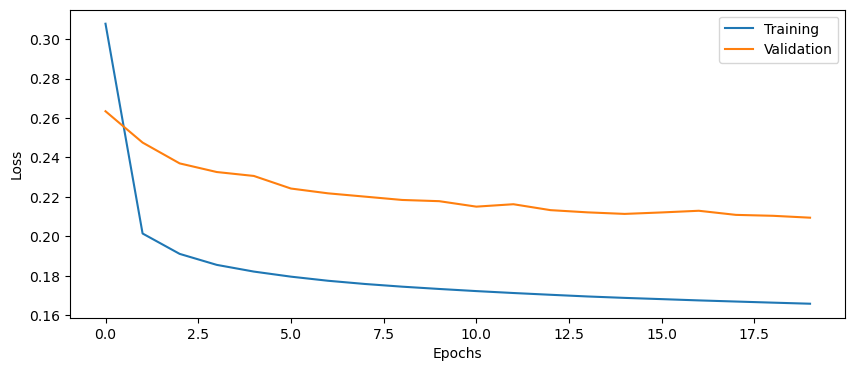

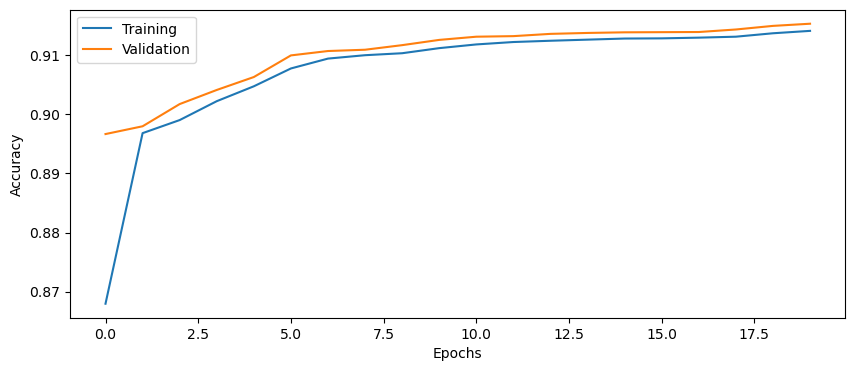

In [36]:
plot_results(history7)

# Part 17: Optimizer

Try changing the optimizer from SGD to Adam (with learning rate 0.1 as before). Remember to import the Adam optimizer from keras.optimizers. 

https://keras.io/optimizers/


### 2 layers, 20 nodes, class weights, Adam optimizer, no batch normalization, sigmoid activations

In [37]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = (Xtrain.shape[1],)

# Build and train model
model8 = build_DNN(input_shape=input_shape, n_layers=2,n_nodes=20,act_fun="sigmoid", optimizer='Adam',learning_rate=0.1)

history8 = model8.fit(Xtrain,Ytrain,batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(Xval,Yval),class_weight=class_weights)

Epoch 1/20
54/54 [==============================] - 7s 58ms/step - loss: 0.2387 - accuracy: 0.8738 - val_loss: 0.2402 - val_accuracy: 0.9025
Epoch 2/20
54/54 [==============================] - 1s 24ms/step - loss: 0.1803 - accuracy: 0.9069 - val_loss: 0.2129 - val_accuracy: 0.9153
Epoch 3/20
54/54 [==============================] - 1s 18ms/step - loss: 0.1658 - accuracy: 0.9160 - val_loss: 0.2001 - val_accuracy: 0.9174
Epoch 4/20
54/54 [==============================] - 1s 16ms/step - loss: 0.1613 - accuracy: 0.9174 - val_loss: 0.1898 - val_accuracy: 0.9193
Epoch 5/20
54/54 [==============================] - 1s 15ms/step - loss: 0.1583 - accuracy: 0.9185 - val_loss: 0.1967 - val_accuracy: 0.9204
Epoch 6/20
54/54 [==============================] - 1s 16ms/step - loss: 0.1560 - accuracy: 0.9188 - val_loss: 0.1841 - val_accuracy: 0.9198
Epoch 7/20
54/54 [==============================] - 1s 17ms/step - loss: 0.1557 - accuracy: 0.9186 - val_loss: 0.1952 - val_accuracy: 0.9197
Epoch 8/20
54

In [38]:
# Evaluate model on test data
score = model8.evaluate(Xtest, Ytest)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

3582/3582 [==============================] - 13s 4ms/step - loss: 0.1695 - accuracy: 0.9266
Test loss: 0.1695
Test accuracy: 0.9266


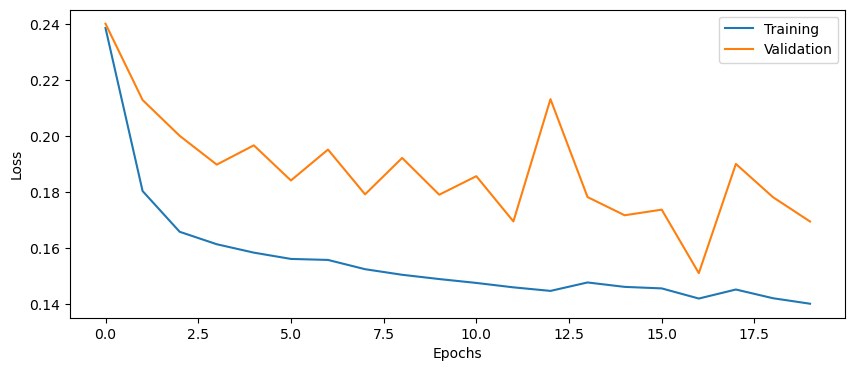

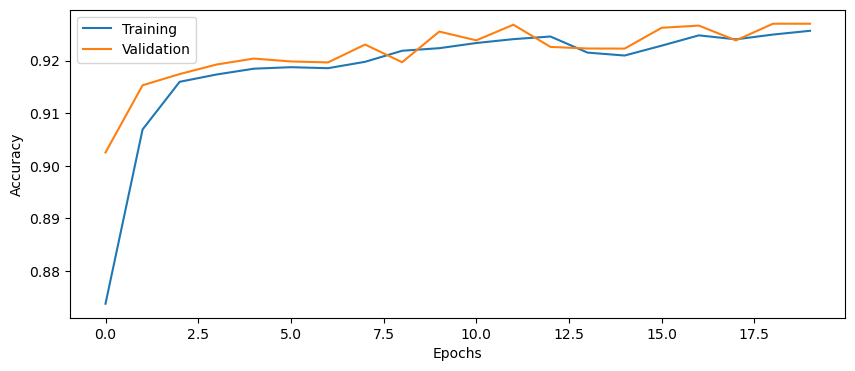

In [39]:
plot_results(history8)

# Part 18: Dropout regularization

Dropout is a type of regularization that can improve accuracy for validation and test data. It randomly removes connections to force the neural network to not rely too much on a small number of weights.

Add a Dropout layer after each Dense layer (but not after the final dense layer) in `build_DNN`, with a dropout probability of 50%. Remember to first import the Dropout layer from keras.layers

See https://keras.io/api/layers/regularization_layers/dropout/ for how the Dropout layer works.

---

Question 15: How does the validation accuracy change when adding dropout?
##### Answer:
Validation accuracy is changed from 92.70% to 88.52%

Question 16: How does the test accuracy change when adding dropout?
##### Answer: 
Test accuracy is changed from 92.66% to 88.60%

### 2 layers, 20 nodes, class weights, dropout, SGD optimizer, no batch normalization, sigmoid activations

In [40]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = (Xtrain.shape[1],)

# Build and train model
model9 = build_DNN(input_shape=input_shape, n_layers=2,n_nodes=20,act_fun="sigmoid", optimizer='sgd',use_dropout=True,learning_rate=0.1)

history9 = model9.fit(Xtrain,Ytrain,batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(Xval,Yval),class_weight=class_weights)

Epoch 1/20
54/54 [==============================] - 8s 62ms/step - loss: 0.6779 - accuracy: 0.5902 - val_loss: 0.6016 - val_accuracy: 0.8769
Epoch 2/20
54/54 [==============================] - 4s 77ms/step - loss: 0.5909 - accuracy: 0.6852 - val_loss: 0.4995 - val_accuracy: 0.8788
Epoch 3/20
54/54 [==============================] - 3s 49ms/step - loss: 0.4948 - accuracy: 0.7726 - val_loss: 0.3986 - val_accuracy: 0.8782
Epoch 4/20
54/54 [==============================] - 3s 47ms/step - loss: 0.4116 - accuracy: 0.8213 - val_loss: 0.3316 - val_accuracy: 0.8779
Epoch 5/20
54/54 [==============================] - 2s 43ms/step - loss: 0.3601 - accuracy: 0.8440 - val_loss: 0.3020 - val_accuracy: 0.8780
Epoch 6/20
54/54 [==============================] - 2s 40ms/step - loss: 0.3295 - accuracy: 0.8554 - val_loss: 0.2882 - val_accuracy: 0.8785
Epoch 7/20
54/54 [==============================] - 2s 35ms/step - loss: 0.3114 - accuracy: 0.8629 - val_loss: 0.2825 - val_accuracy: 0.8788
Epoch 8/20
54

In [41]:
# Evaluate model on test data
score = model9.evaluate(Xtest, Ytest)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

3582/3582 [==============================] - 14s 4ms/step - loss: 0.2601 - accuracy: 0.8860
Test loss: 0.2601
Test accuracy: 0.8860


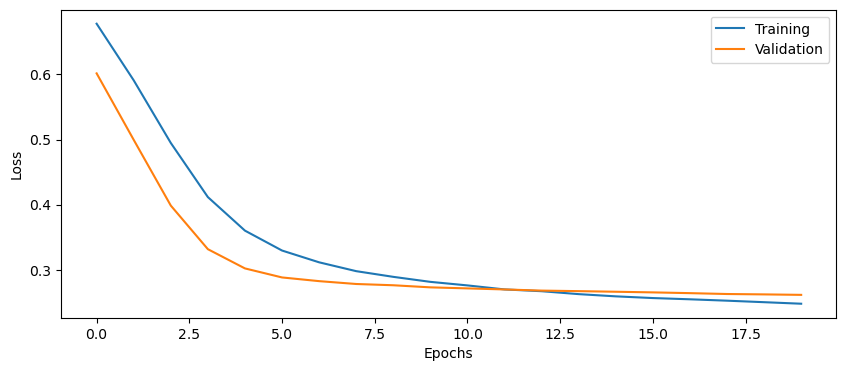

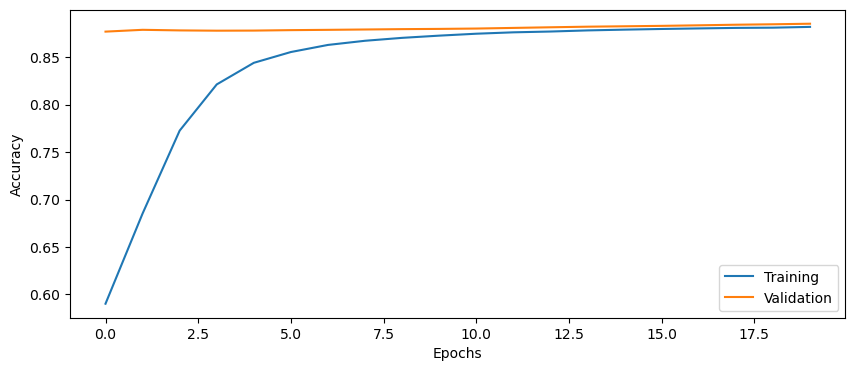

In [42]:
plot_results(history9)

# Part 19: Improving performance

Spend some time (30 - 90 minutes) playing with the network architecture (number of layers, number of nodes per layer, activation function) and other hyper parameters (optimizer, learning rate, batch size, number of epochs, degree of regularization). For example, try a much deeper network. How much does the training time increase for a network with 10 layers?

Question 17: How high classification accuracy can you achieve for the test data? What is your best configuration?
##### Answer:
The highest test accuracy we got is 93.41 % for the following configuration<br>
n_layers=3 <br>
n_nodes=40 <br>
act_fun="sigmoid" <br>
optimizer='Adam' <br>
learning_rate=0.05 <br>
use_dropout=False <br>
use_custom_dropout=False <br>

In [43]:
# Find your best configuration for the DNN

# Build and train DNN
model10 = build_DNN(input_shape=input_shape, n_layers=3,n_nodes=40,act_fun="sigmoid", optimizer='Adam',learning_rate=0.05,use_dropout=False,use_custom_dropout=False)

history10 = model10.fit(Xtrain,Ytrain,batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(Xval,Yval),class_weight=class_weights)


Epoch 1/20
54/54 [==============================] - 6s 44ms/step - loss: 0.2776 - accuracy: 0.8595 - val_loss: 0.2175 - val_accuracy: 0.9134
Epoch 2/20
54/54 [==============================] - 2s 32ms/step - loss: 0.1711 - accuracy: 0.9140 - val_loss: 0.2179 - val_accuracy: 0.9162
Epoch 3/20
54/54 [==============================] - 2s 34ms/step - loss: 0.1662 - accuracy: 0.9167 - val_loss: 0.2152 - val_accuracy: 0.9186
Epoch 4/20
54/54 [==============================] - 2s 45ms/step - loss: 0.1628 - accuracy: 0.9191 - val_loss: 0.2078 - val_accuracy: 0.9201
Epoch 5/20
54/54 [==============================] - 3s 59ms/step - loss: 0.1621 - accuracy: 0.9193 - val_loss: 0.2100 - val_accuracy: 0.9204
Epoch 6/20
54/54 [==============================] - 2s 45ms/step - loss: 0.1601 - accuracy: 0.9202 - val_loss: 0.1984 - val_accuracy: 0.9217
Epoch 7/20
54/54 [==============================] - 2s 33ms/step - loss: 0.1597 - accuracy: 0.9204 - val_loss: 0.2067 - val_accuracy: 0.9206
Epoch 8/20
54

In [44]:
# Evaluate DNN on test data
score = model10.evaluate(Xtest, Ytest)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

3582/3582 [==============================] - 15s 4ms/step - loss: 0.1607 - accuracy: 0.9341
Test loss: 0.1607
Test accuracy: 0.9341


# Part 20: Dropout uncertainty

Dropout can also be used during testing, to obtain an estimate of the model uncertainty. Since dropout will randomly remove connections, the network will produce different results every time the same (test) data is put into the network. This technique is called Monte Carlo dropout. For more information, see this paper http://proceedings.mlr.press/v48/gal16.pdf

To achieve this, we need to redefine the Keras Dropout call by running the cell below, and use 'myDropout' in each call to Dropout, in the cell that defines the DNN. The `build_DNN` function takes two boolean arguments, use_dropout and use_custom_dropout, add a standard Dropout layer if use_dropout is true, add a myDropout layer if use_custom_dropout is true.

Run the same test data through the trained network 100 times, with dropout turned on. 

Question 18: What is the mean and the standard deviation of the test accuracy?
##### Answer:
Mean test accuracy = 91.17% <br>
Standard deviation of test accuracy = 0.0002034

In [45]:
import keras.backend as K
import keras

class myDropout(keras.layers.Dropout):
    """Applies Dropout to the input.
    Dropout consists in randomly setting
    a fraction `rate` of input units to 0 at each update during training time,
    which helps prevent overfitting.
    # Arguments
        rate: float between 0 and 1. Fraction of the input units to drop.
        noise_shape: 1D integer tensor representing the shape of the
            binary dropout mask that will be multiplied with the input.
            For instance, if your inputs have shape
            `(batch_size, timesteps, features)` and
            you want the dropout mask to be the same for all timesteps,
            you can use `noise_shape=(batch_size, 1, features)`.
        seed: A Python integer to use as random seed.
    # References
        - [Dropout: A Simple Way to Prevent Neural Networks from Overfitting](
           http://www.jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)
    """
    def __init__(self, rate, training=True, noise_shape=None, seed=None, **kwargs):
        super(myDropout, self).__init__(rate, noise_shape=None, seed=None,**kwargs)
        self.training = training

        
    def call(self, inputs, training=None):
        if 0. < self.rate < 1.:
            noise_shape = self._get_noise_shape(inputs)

            def dropped_inputs():
                return K.dropout(inputs, self.rate, noise_shape,
                                 seed=self.seed)
            if not training: 
                return K.in_train_phase(dropped_inputs, inputs, training=self.training)
            return K.in_train_phase(dropped_inputs, inputs, training=training)
        return inputs

### Your best config, custom dropout

In [47]:
# Your best training parameters
batch_size=10000
n_layers=3
n_nodes=40
act_fun="sigmoid"
optimizer='Adam'
learning_rate=0.05

# Build and train model
model11 = build_DNN(input_shape=input_shape, n_layers=n_layers,n_nodes=n_nodes,act_fun="sigmoid", optimizer='Adam',learning_rate=0.05,use_dropout=False,use_custom_dropout=True)

history11 = model11.fit(Xtrain,Ytrain,batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(Xval,Yval),class_weight=class_weights)

Epoch 1/20
54/54 [==============================] - 10s 102ms/step - loss: 0.3160 - accuracy: 0.8375 - val_loss: 0.2514 - val_accuracy: 0.9023
Epoch 2/20
54/54 [==============================] - 3s 59ms/step - loss: 0.1968 - accuracy: 0.9046 - val_loss: 0.2370 - val_accuracy: 0.9081
Epoch 3/20
54/54 [==============================] - 4s 81ms/step - loss: 0.1896 - accuracy: 0.9073 - val_loss: 0.2260 - val_accuracy: 0.9107
Epoch 4/20
54/54 [==============================] - 4s 77ms/step - loss: 0.1874 - accuracy: 0.9076 - val_loss: 0.2313 - val_accuracy: 0.9080
Epoch 5/20
54/54 [==============================] - 3s 62ms/step - loss: 0.1858 - accuracy: 0.9083 - val_loss: 0.2256 - val_accuracy: 0.9101
Epoch 6/20
54/54 [==============================] - 3s 59ms/step - loss: 0.1835 - accuracy: 0.9089 - val_loss: 0.2199 - val_accuracy: 0.9110
Epoch 7/20
54/54 [==============================] - 4s 82ms/step - loss: 0.1823 - accuracy: 0.9088 - val_loss: 0.2182 - val_accuracy: 0.9111
Epoch 8/20


In [48]:
# Run this cell a few times to evalute the model on test data, 
# if you get slightly different test accuracy every time, Dropout during testing is working

# Evaluate model on test data
score = model11.evaluate(Xtest, Ytest)
                       
print('Test accuracy: %.4f' % score[1])

3582/3582 [==============================] - 15s 4ms/step - loss: 0.2193 - accuracy: 0.9119
Test accuracy: 0.9119


In [49]:
# Run the testing 100 times, and save the accuracies in an array
accuracy=np.array([])
for i in range(100):
    score=model11.evaluate(Xtest,Ytest)
    accuracy = np.append(accuracy,score[1])
    
    
# Calculate and print mean and std of accuracies
mean_accuracy = np.mean(accuracy)
sd_accuracy = np.std(accuracy)
print(f"Mean of the accuracies: {mean_accuracy:.4f}")
print(f"Standard Deviation of the accuracies: {sd_accuracy:.7f}")


3582/3582 [==============================] - 12s 3ms/step - loss: 0.2197 - accuracy: 0.9117
Mean of the accuracies: 0.9117
Standard Deviation of the accuracies: 0.0002034


# Part 21: Cross validation uncertainty

Cross validation (CV) is often used to evaluate a model, by training and testing using different subsets of the data it is possible to get the uncertainty as the standard deviation over folds. We here use a help function from scikit-learn to setup the CV, see https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html . Use 10 folds with shuffling, random state 1234. 

Note: We here assume that you have found the best hyper parameters, so here the data are only split into training and testing, no validation.

---

Question 19: What is the mean and the standard deviation of the test accuracy?
##### Answer:
Mean of test accuracy = 93.51%
Standard deviation of test accuracy = 0.0017434

Question 20: What is the main advantage of dropout compared to CV for estimating test uncertainty? The difference may not be so large in this notebook, but imagine that you have a network that takes 24 hours to train.
##### Answer:
The main advantage of dropout compared to cross-validation (CV) for estimating test uncertainty is that dropout can be applied during training which is ageneralization technique that randomly droups out some of the neurons which helps the model from overfitting. On the other hand CV is used to estimate the performance of the model on the entirely unseen data but it cannot be used for generalization. 


In [50]:
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import class_weight

# Define 10-fold cross validation
cv_10 = StratifiedKFold(n_splits=10, shuffle=True, random_state=123)

accuracy=np.array([])
# Loop over cross validation folds
for train_index, test_index in cv_10.split(X, Y): 
    Xtrain_fold, Xtest_fold = X[train_index], X[test_index]
    Ytrain_fold, Ytest_fold = Y[train_index], Y[test_index]
    
    # Calculate class weights for current split
    class_weights = class_weight.compute_class_weight(class_weight ='balanced', classes =np.unique(Ytrain_fold), y=Ytrain_fold)
    class_weights = {0: class_weights[0], 1: class_weights[1]}
    batch_size = 1000
    input_shape = (Xtrain_fold.shape[1],)
    # Rebuild the DNN model, to not continue training on the previously trained model
    model_kfold = build_DNN(input_shape=input_shape, n_layers=3,n_nodes=40,act_fun="sigmoid", optimizer='Adam',learning_rate=0.05)
    
    # Fit the model with training set and class weights for this fold
    history_fold = model_kfold.fit(Xtrain_fold,Ytrain_fold,batch_size=batch_size,epochs=epochs,verbose=1)
    
    
    # Evaluate the model using the test set for this fold
    score = model_kfold.evaluate(Xtest_fold, Ytest_fold)
    
    # Save the test accuracy in an array
    accuracy = np.append(accuracy,score[1])

# Calculate and print mean and std of accuracies
mean_accuracy = np.mean(accuracy)
sd_accuracy = np.std(accuracy)
print(f"Mean of the accuracies: {mean_accuracy:.4f}")
print(f"Standard Deviation of the accuracies: {sd_accuracy:.7f}")

Epoch 1/20
688/688 [==============================] - 22s 10ms/step - loss: 0.1561 - accuracy: 0.9155
Epoch 2/20
688/688 [==============================] - 6s 9ms/step - loss: 0.1435 - accuracy: 0.9203
Epoch 3/20
688/688 [==============================] - 4s 6ms/step - loss: 0.1390 - accuracy: 0.9210
Epoch 4/20
688/688 [==============================] - 4s 6ms/step - loss: 0.1326 - accuracy: 0.9266
Epoch 5/20
688/688 [==============================] - 5s 7ms/step - loss: 0.1280 - accuracy: 0.9302
Epoch 6/20
688/688 [==============================] - 5s 7ms/step - loss: 0.1241 - accuracy: 0.9322
Epoch 7/20
688/688 [==============================] - 4s 6ms/step - loss: 0.1218 - accuracy: 0.9338
Epoch 8/20
688/688 [==============================] - 4s 6ms/step - loss: 0.1199 - accuracy: 0.9354
Epoch 9/20
688/688 [==============================] - 5s 8ms/step - loss: 0.1187 - accuracy: 0.9358
Epoch 10/20
688/688 [==============================] - 4s 6ms/step - loss: 0.1199 - accuracy: 0.93

# Part 22: DNN regression

A similar DNN can be used for regression, instead of classification.

Question 21: How would you change the DNN used in this lab in order to use it for regression instead?

#### Answer:
We have to modify the ouput layer to get a continous values instead of binary value. To achieve this
- We should not use any activation function at the output layer.
- We have to use appropriate loss function for regression problem eg MSE.

## Report

Send in this jupyter notebook, with answers to all questions.